In [2]:
#!pip install mahotas
#!pip install git+https://github.com/openai/CLIP.git
#!pip install torch torchvision

In [1]:
import os
import glob
import pandas as pd
import numpy as np
from PIL import Image
from skimage.measure import shannon_entropy
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

from torchvision import models, transforms
import torch
from torchvision.models import resnet18, ResNet18_Weights
try:
    import mahotas
    haralick_available = True
except ImportError:
    print("⚠️ Mahotas not installed – Haralick features won't be used.")
    haralick_available = False

# Przygotuj model ResNet18 bez klasyfikatora
# Załaduj model i wagę
weights = ResNet18_Weights.DEFAULT
resnet = resnet18(weights=weights)
resnet.eval()
resnet_embed = torch.nn.Sequential(*list(resnet.children())[:-1])  # bez klasyfikatora

# Dopasowany transform (rozmiar + normalizacja z ImageNet)
resnet_transform = weights.transforms()

def extract_features_from_folders(folder_paths):
    all_features = []

    for folder_path in folder_paths:
        folder_path = os.path.normpath(folder_path)
        image_paths = glob.glob(os.path.join(folder_path, '**', '*.jpg'), recursive=True)
        image_paths += glob.glob(os.path.join(folder_path, '**', '*.png'), recursive=True)

        if len(image_paths) == 0:
            print(f"⚠️ Brak obrazków w folderze: {folder_path}")
            continue

        for image_path in image_paths:
            try:
                img = Image.open(image_path).convert('RGB')  # ResNet wymaga RGB
                img_gray = img.convert('L')
                img_array = np.array(img_gray).astype(np.uint8)

                # Statystyki z obrazu szarego
                features = {
                    'path': image_path,
                    'mean_intensity': np.mean(img_array),
                    'std_intensity': np.std(img_array),
                    'min_intensity': np.min(img_array),
                    'max_intensity': np.max(img_array),
                    'skewness': skew(img_array.flatten()),
                    'kurtosis': kurtosis(img_array.flatten()),
                    'entropy': shannon_entropy(img_array)
                }

                # Haralick
                if haralick_available:
                    h = mahotas.features.haralick(img_array).mean(axis=0)
                    for i, val in enumerate(h):
                        features[f'haralick_{i+1}'] = val

                # Embedding ResNet
                input_tensor = resnet_transform(img).unsqueeze(0)  # dodaj batch dimension
                with torch.no_grad():
                    embedding = resnet_embed(input_tensor).squeeze().numpy()  # [512]
                for i, val in enumerate(embedding):
                    features[f'resnet_emb_{i+1}'] = val

                all_features.append(features)

            except Exception as e:
                print(f"❌ Błąd przy {image_path}: {e}")

    if len(all_features) == 0:
        print("🚫 Nie znaleziono żadnych poprawnych obrazków. Nie tworzę pliku.")
        return None

    df = pd.DataFrame(all_features)

    # Zapis
    os.makedirs("data_tables", exist_ok=True)
    base_name = '_'.join([os.path.basename(path.rstrip('/\\')) for path in folder_paths])
    output_csv = f"data_tables/features_from_{base_name}.csv"
    df.to_csv(output_csv, index=False)

    # Statystyki
    print(f"\n📊 Statystyki cech ({output_csv}):\n")
    print(df.describe())

    # Wizualizacja cech (nie embeddingów, tylko bazowe)
    plot_cols = ['mean_intensity', 'std_intensity', 'entropy', 'skewness', 'kurtosis', 'min_intensity']
    existing_cols = [col for col in plot_cols if col in df.columns]
    df[existing_cols].hist(bins=20, figsize=(14, 6))
    plt.suptitle(f'Cechy z folderów: {base_name}')
    plt.tight_layout()
    plt.show()

    # Wizualizacja wybranych wymiarów embeddingów
    embed_cols = [col for col in df.columns if col.startswith('resnet_emb_')]
    if embed_cols:
        df[embed_cols[:5]].hist(bins=20, figsize=(14, 6))
        plt.suptitle(f'Embeddingi ResNet (pierwsze 5) – {base_name}')
        plt.tight_layout()
        plt.show()

    return df


c:\Users\66891\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\66891\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Przetwarzam folder: DATA/rotated-cutted

📊 Statystyki cech (data_tables/features_from_rotated-cutted.csv):

       mean_intensity  std_intensity  min_intensity  max_intensity  \
count     4780.000000    4780.000000         4780.0    4780.000000   
mean        63.928749      86.226528            0.0     253.727824   
std         24.057630      12.512336            0.0       2.115265   
min          0.548509      10.405519            0.0     226.000000   
25%         47.636106      85.409597            0.0     253.000000   
50%         68.800741      90.873571            0.0     254.000000   
75%         82.529167      93.395594            0.0     255.000000   
max        152.984295     111.232963            0.0     255.000000   

          skewness     kurtosis      entropy   haralick_1   haralick_2  \
count  4780.000000  4780.000000  4780.000000  4780.000000  4780.000000   
mean      1.061298     0.585592     3.849720     0.322893   807.197763   
std       1.099535     9.092421     1.3

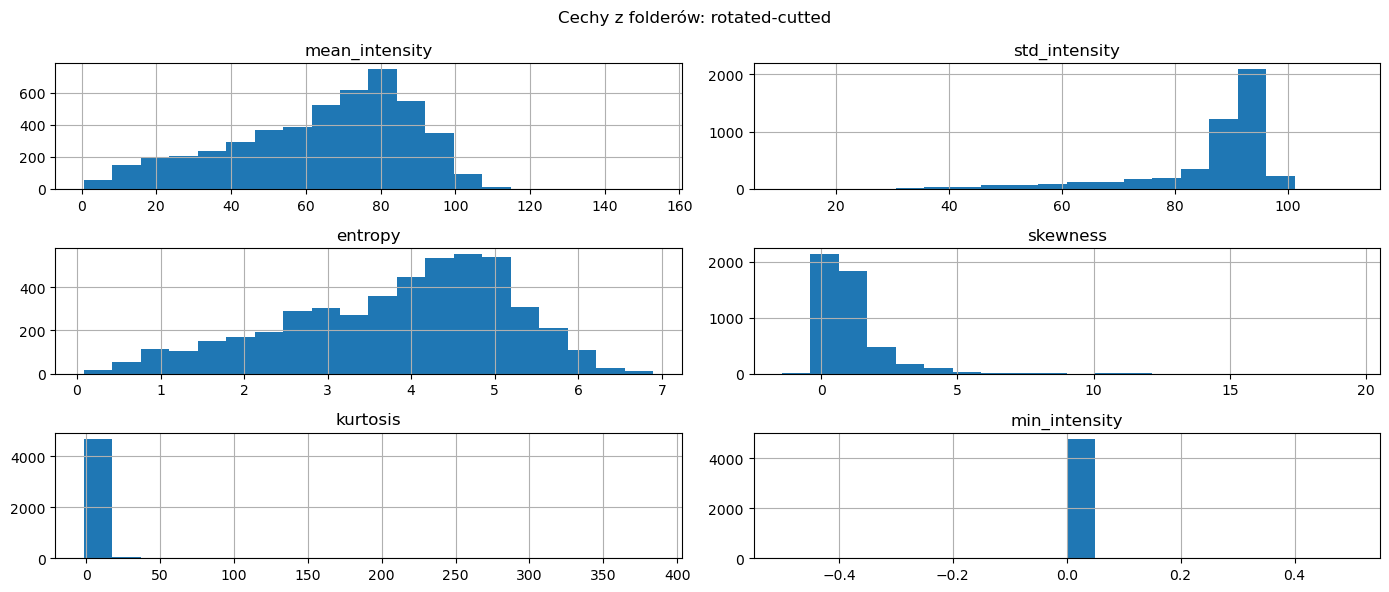

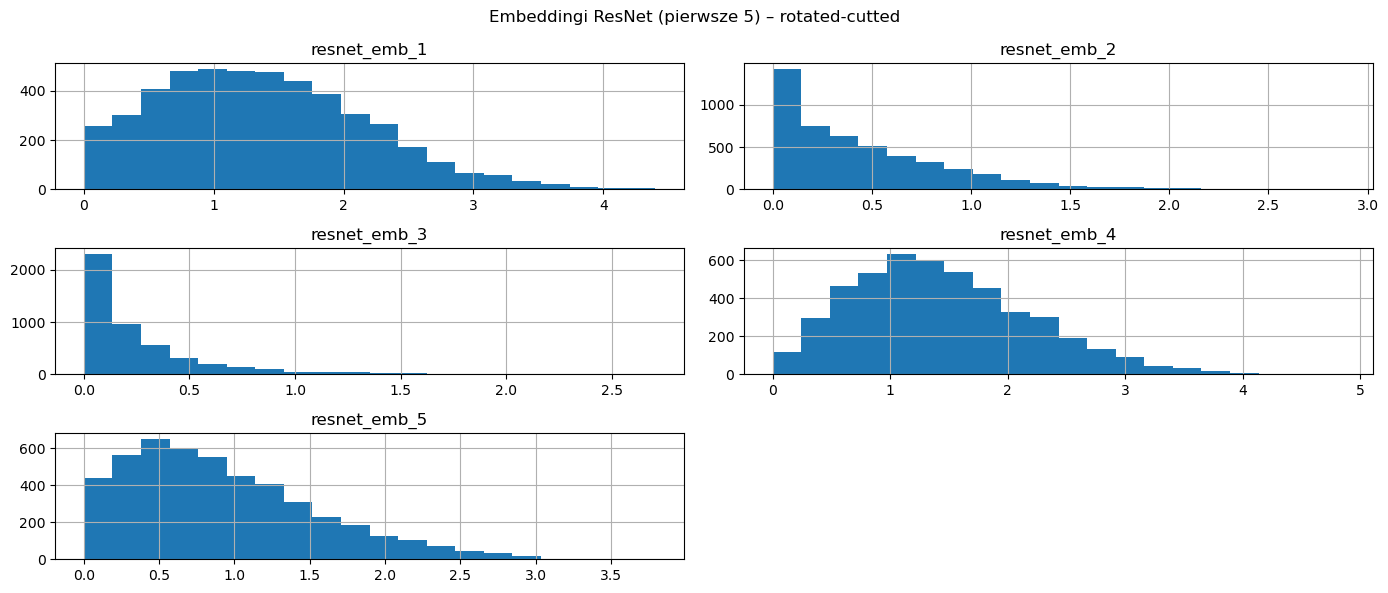

Przetwarzam folder: DATA/Rotated_Klasteryzacja

📊 Statystyki cech (data_tables/features_from_Rotated_Klasteryzacja.csv):

       mean_intensity  std_intensity  min_intensity  max_intensity  \
count     4780.000000    4780.000000         4780.0    4780.000000   
mean       119.989996      70.492656            0.0     253.889331   
std          9.471192       5.399127            0.0       1.296934   
min         35.282246      40.686472            0.0     245.000000   
25%        114.893156      68.073818            0.0     253.000000   
50%        119.000100      71.198727            0.0     254.000000   
75%        123.536487      73.844818            0.0     255.000000   
max        193.879783      99.754904            0.0     255.000000   

          skewness     kurtosis      entropy   haralick_1   haralick_2  \
count  4780.000000  4780.000000  4780.000000  4780.000000  4780.000000   
mean     -0.055319    -0.841579     7.535154     0.006955   588.703574   
std       0.302412     0.

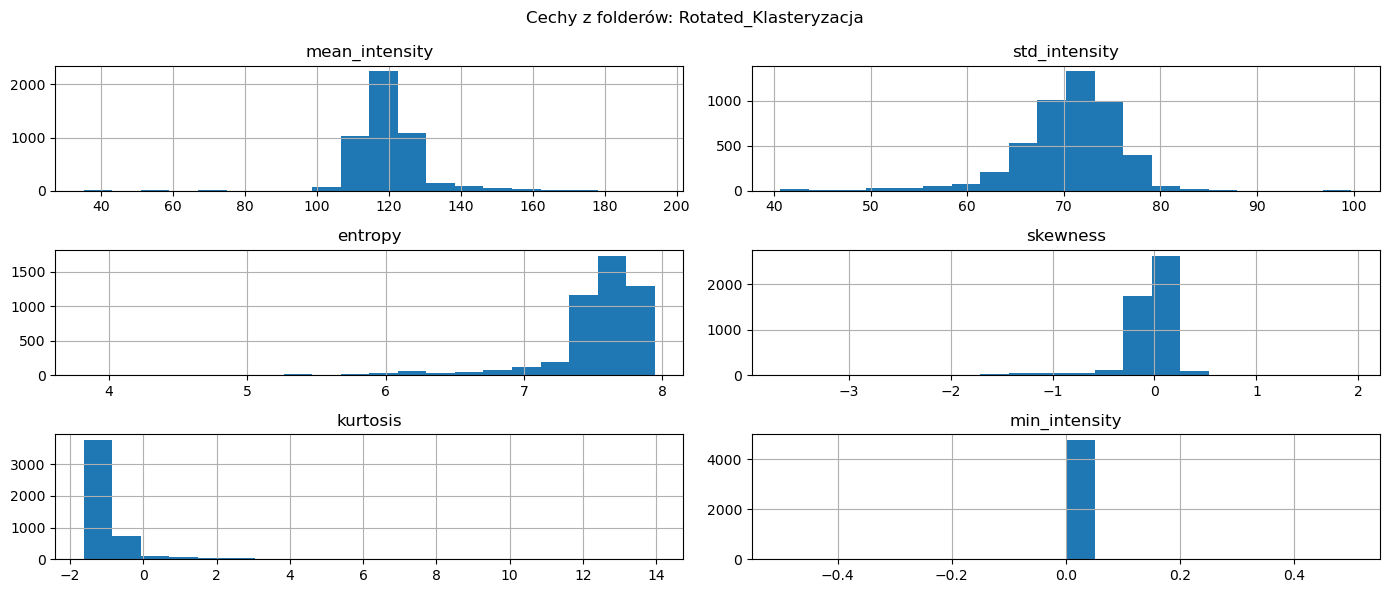

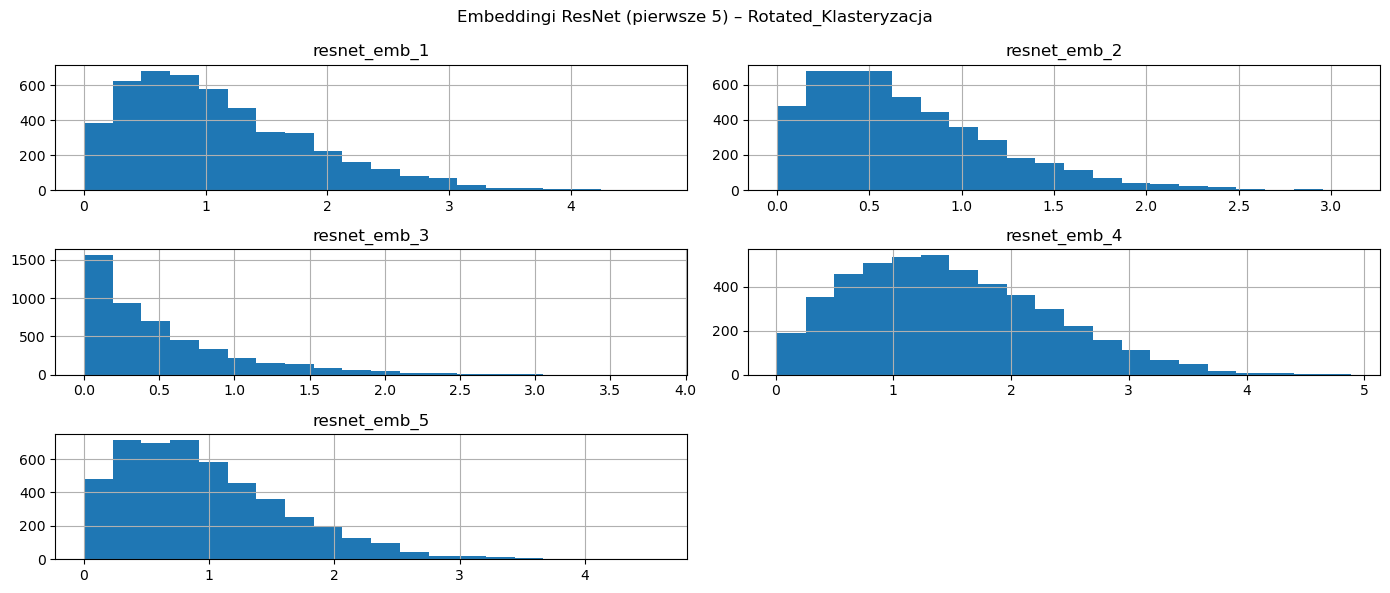

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
base_folder = "DATA"
#subfolders = [os.path.join(base_folder, f) for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]
subfolders = ["DATA/rotated-cutted", "DATA/Rotated_Klasteryzacja"]
for folder in subfolders:
    print(f"Przetwarzam folder: {folder}")
    extract_features_from_folders([folder])  # funkcja z poprzednich kroków
